In [1]:
! pip install transformers
! pip install konlpy
! pip install kss

     |████████████████████████████████| 1.3MB 6.2MB/s 
     |████████████████████████████████| 1.1MB 25.5MB/s 
     |████████████████████████████████| 2.9MB 60.3MB/s 
     |████████████████████████████████| 890kB 55.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=05fff829c7f3d9becd9d019e799b3f5ed33370408bbf3168b38a8e80dc3b3a37
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 55.1MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchtext
from google.colab import drive
from konlpy.tag import Okt
from torch.autograd import Variable, grad
from transformers import AdamW,get_linear_schedule_with_warmup,get_constant_schedule_with_warmup
import time
import datetime
import pickle
import kss
from sklearn.metrics import confusion_matrix,classification_report
drive.mount('/content/gdrive')
os.chdir('./gdrive/My Drive/기상청')

Mounted at /content/gdrive


# 1. 데이터 전처리 작업 
## Cleansing
## Tokenizing


In [41]:
# 데이터 불러오기
data=pd.read_csv('./Final_data.csv',header=0)

In [42]:
data

,Title,maintext,피해
0,"동국대일산병원, 무더위 속 '얼음생수 나눔 캠페인' 펼쳐",동국대학교 일산병원(병원장 이해원)은 병원 정문 앞 버스 승강장과 택시 승강장에서 ...,0
1,폭염에 따른 하수처리장 및 공공하수도 안전점검,연천군 맑은물관리사업소는 연일 이어지는 폭염속에 식수 및 생활용수 등 하수 사용량이...,0
2,"가평군, 물놀이 취약시설 안전점검 강화",▲ 물놀이취약시설현장점검나서\n\n\n\n김성기 가평군수가 폭염으로 증가하는 물놀이...,0
3,"용인송담대, 슈퍼쿨비즈 시범운영한다",▲ 대학교에서도 시행되는 용인송담대 '슈퍼쿨비즈(Supe Cool Biz)' 시범운...,0
4,"이천소방서, 한국119소년단 '불나면 대피먼저'캠페인 실시",▲한국119소년단 ‘불나면 대피먼저’캠페인\n\n\n\n이천소방서(서장 고문수)는 ...,0
...,...,...,...
8043,경북지역 폭염특보 해제됐지만 37일간 온열질환자 약 300명 발생,"가축 60만 마리 가량 폐사하고, 농작물 피해도 1천200여㏊\n\n37일간 경북지...",1
8044,문경에서 90대 할머니 온열질환으로 사망,폭염이 이어지는 가운데 경북지역 온열질환 사망자가 또 나왔다.\n\n3일 경북도 등...,1
8045,경북 첫 온열질환 사망자 발생,"42세 여성 집에서 쓰러져 병원 옮겼으나 숨져, 경북도 온열질환 사망으로 추정\n\...",1
8046,전국 기록적 폭염에 온열질환 주의보 풀 뽑다 1명 사망,군인의 더위 탈출 /사진=연합뉴스\n\n전국에 기록적인 폭염이 이어지고 있다.기상청...,1


1. [\n]+은 빈칸으로 치환
2. 괄호 안에 들어 간 것과 괄호 들은 제거
3. 숫자는 # 으로 치환
4. [/사진=연합뉴스],기자,배포금지,무단배포,@ 등이 들어가 있는 문장의 경우 아예 삭제
5. 토큰화 된 문장의 길이가 3 이하 인 경우 제거


In [37]:
def cleansing(text):
    # \n -> ' '
    text=text
    text=re.sub('\n+',' ',text)
    # 괄호 제거
    text=re.sub('\(.+?\)|\[.+?\]|\<.+?\>','',text)
    # 한글, ., ,숫자가 아닌 경우 빈칸으로 치환
    text=re.sub('[^ ㄱ-ㅣ가-힣,.0-9]+','',text)
    # 숫자 #으로 치환
    text=re.sub('[0-9]+','#',text)
    # 문장 분리기를 활용해서 불용어가 있는 경우 제거
    result=[]
    for sentence in kss.split_sentences(text):
        for i in ['사진','기자','배포금지','무단배포','@','뉴스룸','닷컴']:
            if i in sentence:
                break
        else:
            result.append(sentence)
    return ' '.join(result)

In [43]:
data['제목']=data['Title'].apply(lambda i : cleansing(i))
data['본문']=data['maintext'].apply(lambda i : cleansing(i))

In [68]:
data['total']=data['제목']+'. '+data['본문']
data['Total']=data['제목'].apply(lambda i : [i])+data['본문'].apply(lambda i : [sentence for sentence in kss.split_sentences(i)])

기사 단위의 본문을 그대로 tokenize시키고, 이를 input으로 넣어서 기사 classification 작업 진행 예정

## Train Test split
Train, Test split

우리가 목표로 하는 피해인 기사가 너무 적어서 Train, Test로만 split 진행 (10%만 Test)

In [74]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(data,test_size=0.1)

In [75]:
print((train_data.피해!=0).sum()/len(train_data)) #16%
print((test_data.피해!=0).sum()/len(test_data)) #16%

0.16139721110037278
0.1639751552795031


In [77]:
# Train data만을 Tokeninze시키기
# by Okt
from konlpy.tag import Okt
tokenizer=Okt()
tokenized=[]
Tokenized=[]
for i in train_data.Total:
    result=[]
    for j in i:
        result.append(tokenizer.morphs(j,stem=True))
    Tokenized.append(result)
    tokenized.extend(result)

395.4720419715587
7381
2


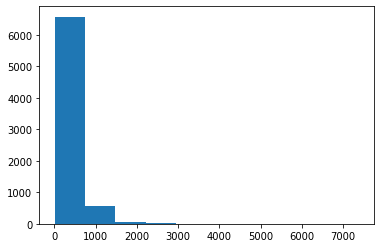

In [78]:
# 한 기사마다 평균적으로 제목+본문의 길이가 어느 정도 되는 지 파악한다.
for_len=[sum(list(map(len,i))) for i in Tokenized]
plt.hist(for_len)
print(np.array(for_len).mean()) # 512 수준으로 해보자
print(np.array(for_len).max())
print(np.array(for_len).min())

array([['동국대일산병원, 무더위 속 얼음생수 나눔 캠페인 펼쳐. 동국대학교 일산병원은 병원 정문 앞 버스 승강장과 택시 승강장에서 대중교통 운전기사들을 대상으로 얼음생수 나눔 캠페인을 진행 중이라고 #일 밝혔다. 이번 이벤트는 연일 지속되는 폭염에 병원을 오가는 대중교통 운전기사들에게 무더위로 인한 온열병 예방과 안전운전을 위해 마련됐으며 지난해 높은 호응으로 올해에도 이어지고 있다. 생수 나눔 캠페인은 오전 #시부터 오후 #시까지이며 점심시간을 제외한 나머지 시간을 이용해 교직원들이 직접 생수를 제공한다. 택시를 운행하는 한 운전기사는 무더운 날씨에 뜻밖의 얼음생수를 받아 정말 감사하다며 시원한 물을 마시니 잠시나마 더위가 잊혀지는 것 같다고 감사 인사를 했다.'],
       ['폭염에 따른 하수처리장 및 공공하수도 안전점검. 연천군 맑은물관리사업소는 연일 이어지는 폭염속에 식수 및 생활용수 등 하수 사용량이 증가함에 따라 하수처리장, 하수관로 및 하수중계펌프에 대해 긴급점검을 실시했다고 #일 밝혔다. 이번 하수처리장 점검은 연천, 임진, 청산, 백학, 원당, 신서하수처리장을 대상으로 각종 장비 및 시설물 운영실태 전반에 대해 이뤄졌다. 주요 점검 내용은  공공하수처리시설 운영 관련 적정관리 여부 운영관련 일지 및 준수사항 이행 등이었으며, 불명수 하수관로 #와 중계펌프장 #개소에 대해서는 환경기초시설 운영대행 업체로 하여금 일일 순찰도록 해 여름철 악취예방 및 갑작스런 집중호우에 대비토록 했다. 군 맑은물관리사업소 박광근 소장은 수돗물을 사용한 만큼 하수량이 증가되기 때문에 하수처리장 운영전반에 대해 꼼꼼히 점검, 군민이 일상생활에 불편을 겪지 않도록 하기 위해 점검을 실시했다며 공공하수도 준설을 통한 악취예방으로 무더위로 부터 냄새없는 마을 만들기에 최선을 다하겠다고 말했다.'],
       ['가평군, 물놀이 취약시설 안전점검 강화. 물놀이취약시설현장점검나서 김성기 가평군수가 폭염으로 증가하는 물놀이 인구의 안전사고 예방을 위해 취약시설 안

## Train data Under sampling을 진행해서 프로젝트 진행

In [140]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(data['total'].values.reshape(-1,1), data['피해'].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [145]:
Under_data=pd.DataFrame({'total':X_under.reshape(-1),'피해':y_under.reshape(-1)})
Under_data.to_csv('under_train.csv',index=False,encoding='utf-8')

In [79]:
# word2vec 진행
from gensim.models import Word2Vec
model=Word2Vec(size=128,window=3,min_count=3)
model.build_vocab(tokenized)
print(len(model.wv.vocab)) 

# word2vec 저장
model.wv.save_word2vec_format('./wv_128')
# torchtext로 구성해낸다.

# 관건 align 작업
vectors=torchtext.vocab.Vectors('wv_128',cache='./')

23818


 98%|█████████▊| 23334/23818 [00:01<00:00, 19002.45it/s]


In [80]:
# train, test data 저장
train_data.loc[:,['total','피해']].to_csv('./train_data.csv',index=False)
test_data.loc[:,['total','피해']].to_csv('./test_data.csv',index=False)

In [81]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [92]:
config=Config({'embedding_dim':128,'hidden_dim':256,'seq_len':512,'batch_size':32,'dense_dim':32,'dropout':0.3,'num_layers':1,'padding_idx':1})

In [146]:
# 1 preprocessing
# torchtext를 활용하면 한방에(tokenize,wordembedding,padding ...)
# SOS,EOS,padding,fix_len : 50
import torchtext
# Field 정의 ~ 빅데이터 시스템 및 계산에서 공부한 column과 비슷
# Text <- padding 하지 말아라
Text=torchtext.data.Field(sequential=True,use_vocab=True,batch_first=True,tokenize=lambda i : okt.morphs(i,stem=True),lower=False,fix_length=config.seq_len,init_token='<SOS>',eos_token='<EOS>',pad_token='<PAD>',unk_token='<UNK>')
Target=torchtext.data.Field(sequential=False,use_vocab=False,batch_first=True,is_target=True)

# Data 정의
Train_data=torchtext.data.TabularDataset('./under_train.csv',format='csv',fields=[('total',Text),('피해',Target)],
                                           skip_header=True)
Test_data=torchtext.data.TabularDataset('./test_data.csv',format='csv',fields=[('total',Text),('피해',Target)],
                                           skip_header=True)

In [147]:
# load embeddings using torchtext
Text.build_vocab(Train_data,min_freq=3,vectors=vectors)

In [148]:
print(Text.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fbf99348950>, {'<UNK>': 0, '<PAD>': 1, '<SOS>': 2, '<EOS>': 3, '.': 4, '하다': 5, '이': 6, '을': 7, '에': 8, ',': 9, '가': 10, '의': 11, '를': 12, '으로': 13, '있다': 14, '은': 15, '는': 16, '되다': 17, '#': 18, '폭염': 19, '등': 20, '것': 21, '한': 22, '이다': 23, '과': 24, '에서': 25, '들': 26, '도': 27, '로': 28, '수': 29, '하고': 30, '적': 31, '#일': 32, '와': 33, '피해': 34, '돼다': 35, '인': 36, '열': 37, '보다': 38, '발생': 39, '#월': 40, '지역': 41, '따르다': 42, '고': 43, '않다': 44, '다': 45, '온': 46, '질환': 47, '에는': 48, '지난': 49, '#만': 50, '전': 51, '까지': 52, '기온': 53, '말': 54, '올해': 55, '#년': 56, '자': 57, '없다': 58, '가격': 59, '장': 60, '지난해': 61, '원': 62, '이상': 63, '많다': 64, '더위': 65, '관리': 66, '오다': 67, '및': 68, '전국': 69, '같다': 70, '#도': 71, '양식': 72, '위해': 73, '높다': 74, '달': 75, '수온': 76, '일': 77, '서울': 78, '경우': 79, '비': 80, '때문': 81, '무더위': 82, '인하다': 83, '시': 84, '중': 85, '오르다': 86, '최고': 87, '계속': 88, '기록': 89, '받다': 90, '#.#': 91, '날': 92, '여름': 93, '대비': 94, '폐': 95, '때': 96, 

In [149]:
print(len(Text.vocab.stoi))

13468


In [85]:
# 다 같은 것을 입증
# freq가 달라도, vectors에 있던 것만 들어가게 된다.
result=[]
for vocab,_ in vectors.stoi.items():
    r=vectors.vectors[_]==Text.vocab.vectors[Text.vocab.stoi[vocab]]
    result.append(np.all(r.numpy()))
print(np.all(np.array(result)))

True


In [150]:
train_loader=torchtext.data.Iterator(Train_data,batch_size=config.batch_size)
test_loader=torchtext.data.Iterator(Test_data,batch_size=config.batch_size)

In [151]:
batch=next(iter(train_loader))
print(batch.total)
print(batch.피해)

tensor([[   2, 3265,  628,  ...,   10,  225,    3],
        [   2,  179,   19,  ...,    1,    1,    1],
        [   2, 2230,   19,  ...,    1,    1,    1],
        ...,
        [   2, 2702, 6907,  ...,  141, 6554,    3],
        [   2, 5783, 3656,  ...,    1,    1,    1],
        [   2, 4107,  593,  ..., 2093, 3063,    3]])
tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0])


In [152]:
class lstm_model(nn.Module):
    def __init__(self,config,vectors):
        super().__init__()
        self.config=config
        self.embedding=nn.Embedding.from_pretrained(vectors,freeze=False,padding_idx=self.config.padding_idx)
        self.lstm=nn.LSTM(self.config.embedding_dim,self.config.hidden_dim,bidirectional=True,batch_first=True)
        self.classifier=nn.Sequential(nn.Linear(2*self.config.hidden_dim,self.config.dense_dim),nn.ReLU(),nn.Linear(self.config.dense_dim,2))
        # classifier 부분의 마지막 단은, 어차피 cross entropy를 활용할 것이기 때문에 굳이 sigmoid를 취하지 않아도 된다.
        self.dropout=nn.Dropout(self.config.dropout)
    def forward(self,input):
        '''
        input shape : batch size, seq_len 
        '''
        embed=self.embedding(input) # batch size, seq_len, embedding_dim
        embed=self.dropout(embed)
        input,(hidden,cell)=self.lstm(embed) # input shape  :batch size, seq len, hidden dim
        input=input[:,-1,:] # batch size, 2*hidden dim
        pred=self.classifier(input) # pred shape : batch size, 2
        return pred

In [176]:
# train
import time
device = 'cuda:0'
model = lstm_model(config,Text.vocab.vectors)
model.to(device)
# Criterion
criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-4, # 학습률
                  eps = 1e-8, # 0으로 나누는 것을 막아준다.
                  weight_decay=0.3
                )
# 에폭수
epochs = 100

In [171]:
# 시간 표시 함수
import datetime
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [177]:
start_time=time.time()
for epoch in range(1,epochs+1):
    model.train()
    total_loss=0
    total_acc=0
    for batch in train_loader:
        x=batch.total.to(device)
        y=batch.피해.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss=criterion(pred,y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) 
        optimizer.step()   
        total_loss+=loss.item()
        acc=(pred.argmax(-1)==y).float().mean()
        total_acc+=acc
    if epoch%10==0:
        print("EPOCH : %d"%epoch)
        print("| TRAIN_LOSS : %.4f | TRAIN_ACC : %.4f | Eplased time : %s"\
            %(total_loss/len(train_loader),total_acc/len(train_loader),format_time(time.time()-start_time)))
        

            

EPOCH : 10
| TRAIN_LOSS : 0.4837 | TRAIN_ACC : 0.7950 | Eplased time : 0:00:40
EPOCH : 20
| TRAIN_LOSS : 0.3564 | TRAIN_ACC : 0.8704 | Eplased time : 0:01:20
EPOCH : 30
| TRAIN_LOSS : 0.2944 | TRAIN_ACC : 0.9009 | Eplased time : 0:02:01
EPOCH : 40
| TRAIN_LOSS : 0.2916 | TRAIN_ACC : 0.9017 | Eplased time : 0:02:41
EPOCH : 50
| TRAIN_LOSS : 0.2930 | TRAIN_ACC : 0.9008 | Eplased time : 0:03:22
EPOCH : 60
| TRAIN_LOSS : 0.2840 | TRAIN_ACC : 0.9035 | Eplased time : 0:04:03
EPOCH : 70
| TRAIN_LOSS : 0.2831 | TRAIN_ACC : 0.9020 | Eplased time : 0:04:44
EPOCH : 80
| TRAIN_LOSS : 0.2945 | TRAIN_ACC : 0.8973 | Eplased time : 0:05:25
EPOCH : 90
| TRAIN_LOSS : 0.3043 | TRAIN_ACC : 0.8944 | Eplased time : 0:06:05
EPOCH : 100
| TRAIN_LOSS : 0.3177 | TRAIN_ACC : 0.8852 | Eplased time : 0:06:46


## TRAIN

In [199]:
model.eval()
total_loss=0
total_acc=0
Pred=[]
TruE=[]
for batch in train_loader:
    x=batch.total.to(device)
    y=batch.피해.to(device)
    pred = model(x)
    loss=criterion(pred,y)
    total_loss+=loss.item()
    acc=(pred.argmax(-1)==y).float().mean()
    total_acc+=acc
    Pred.extend(pred.argmax(-1).cpu().tolist())
    TruE.extend(y.cpu().tolist())

print("| TRAIN_LOSS : %.4f | TRAIN_ACC : %.4f |"\
    %(total_loss/len(train_loader),total_acc/len(train_loader)))   
print(classification_report(TruE,Pred))     

model.eval()
total_loss=0
total_acc=0
Pred=[]
TruE=[]
for batch in test_loader:
    x=batch.total.to(device)
    y=batch.피해.to(device)
    pred = model(x)
    loss=criterion(pred,y)
    total_loss+=loss.item()
    acc=(pred.argmax(-1)==y).float().mean()
    total_acc+=acc
    Pred.extend(pred.argmax(-1).cpu().tolist())
    TruE.extend(y.cpu().tolist())

print("| TEST_LOSS : %.4f | TEST_ACC : %.4f |"\
    %(total_loss/len(test_loader),total_acc/len(test_loader)))          
print(classification_report(TruE,Pred))

| TRAIN_LOSS : 0.2833 | TRAIN_ACC : 0.9031 |
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1301
           1       0.88      0.94      0.91      1301

    accuracy                           0.90      2602
   macro avg       0.91      0.90      0.90      2602
weighted avg       0.91      0.90      0.90      2602

| TEST_LOSS : 0.4964 | TEST_ACC : 0.8060 |
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       673
           1       0.45      0.92      0.61       132

    accuracy                           0.81       805
   macro avg       0.72      0.85      0.74       805
weighted avg       0.89      0.81      0.83       805



In [178]:
torch.save(model.state_dict(),'./model_w2v_lstm_1')